#### **Computer Vision**


#### **1. Image Augmentation**

In order to obtain definitve results during prediction, we applu image augmentation in training and not use augmentation during prediction. DL frameworks provide many augmentation methods that can be applied simultaneously.

In [ ]:
'''
Most image augmentation methods have a degree of randomness.
Common image augmentation methods
- flipping left and right, and Cropping
- changing color (brightness, contrast, saturation and hue)
- defining apply augmentation function (custom method)
- combining multiple image augmentation methods

We start with a method that runs augmentation multiple times on input iamge
'''
def apply(img, aug, num_rows=1, num_cols=6, scale=1.5):
    Y = [aug(img) for _ in range(num_cols * num_rows)]
    show_images(Y, num_rows, num_cols, scale=scale)

In [ ]:
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
color_aug = torchvision.transforms.ColorJitter(brightness=.1, contrast=0, saturation=0, hue=0.1)
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])

Training with Images

In [ ]:
all_imgs = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)

100%|██████████| 170M/170M [00:19<00:00, 8.92MB/s]


In [ ]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),torchvision.transforms.ToTensor()])
test_augs = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=augs, download=True)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4)

def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="../data", train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, num_workers=4)
    return dataloader

In [ ]:
''' define a function to train and evaluate the model using multi-GPUs '''
def train_batch(model, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    model.train()
    trainer.zero_grad()
    pred = model(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

''' train wth multiple GPUs '''
def train(model, train_iter, test_iter, loss, trainer, num_epochs,
          devices=gpus):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    num_batches = len(train_iter)
    net = nn.DataParallel(model, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss: {metric[0] / metric[2]:.3f}, train acc: {metric[1] / metric[2]:.3f}, '
          f'test acc: {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

In [ ]:
batch_size, devices, net = 256, gpus, resnet18(10, 3)
net.apply(init_cnn)

def train_with_augmented_data(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=0.1)
    net(next(iter(train_iter))[0]) #.to(devices[0]))
    train(net, train_iter, test_iter, loss, trainer, 10, devices)

loss: 0.210, train acc: 0.928, test acc: 0.853
511.4 examples/sec on ['cuda:0']


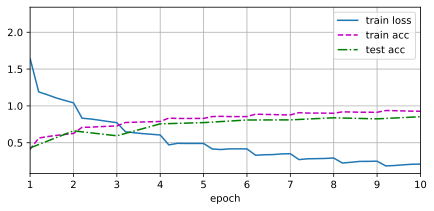

In [ ]:
train_with_augmented_data(train_augs, test_augs, net)

#### **2. Fine-Tuning Model**

In [ ]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.ToTensor() ])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor() ])

dataset = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=augs, download=True)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=4)

def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="../data", train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, num_workers=4)
    return dataloader

In [ ]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.fc

In [ ]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

In [ ]:
''' define the training function that uses fine-tuning '''def train_fine_tuning(
    net, learning_rate, batch_size=128, num_epochs=1,param_group=True):

    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD(
          [{'params': params_1x}, {'params': net.fc.parameters(), 'lr': learning_rate*10}],
          lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    train(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

#### **3. Fully Convoluted Networks**

A fully convolutional network (FCN) uses a convolutional network to transform image pixels to pixel classes. Unlike CNN for image classification or object detection, fcn transforms the height and the width of intermediate feature maps back to those of the input image. This is achieved by the transposed convolutional layer.

As a result the classification output and the input image have a one-to-one correspondence in pixel levels - the channel dimension of any input pixel holds the classification results for the input pixel at the same spatial position.

In [ ]:
''' Use Resnet-18 model pretrained on the image dataset to extract features '''
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net.eval()
list(pretrained_net.children())[-3:]

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [ ]:
''' create the fully convolutional network instance '''
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [ ]:
''' given an input image with the forward prop reduces the size significantly '''
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [ ]:
''' use convolutional layer to transform the number of output classes
we need to increase by 32 times the dimensions height/width '''
num_classes = 21
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                kernel_size=64, padding=16, stride=32))


In [ ]:
''' Initialize Transposed Convolutional Layers
upsampling -- bilinear interpolation is a commonly used technique of upsampling
'''
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1: center = factor - 1
    else: center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1),
          torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

''' upsampling of bilinear interpolation '''
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

''' read image X and assign the upsampling output to Y
from PIL import Image
img_ = torchvision.transforms.ToTensor()(Image.open('20250109_071110.jpg'))
Y = conv_trans(img_.unsqueeze(0))
out_img_ = Y[0].permute(1, 2, 0).detach() #.numpy()

set_figsize()
plt.imshow(out_img_)
''';

In [ ]:
''' in fcn initialize the transposed conv layer with upsampling of bilinear interpolation '''
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W)

In [ ]:
''' read from semantic segmentation dataset '''
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

/tmp/ipython-input-2094893403.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  fp.extractall(base_dir)


read 1114 examples
read 1078 examples


In [ ]:
''' Training '''
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, gpus
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
train(net, train_iter, test_iter, loss, trainer, num_epochs)

In [ ]:
''' Prediction
Standardize the input image in each channel and transform the image into 4-dim
input format required by CNN
'''
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

''' To visualize the predicted class of each pixel, we map the predicted class
back to its label color in the dataset '''
def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

In [ ]:
''' crop multiple rectangular areas with height and width that are integer
multiples of 32 in the image, to perform forward prop in the pixels in these
areas separately. The union of these rectangular areas covers the input image '''
voc_dir = download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
test_images, test_labels = read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    # Move tensors to CPU before adding to the list
    imgs += [X.permute(1, 2, 0).detach().cpu().numpy(),
             pred.detach().cpu().numpy(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1, 2, 0).cpu().numpy()]

# Create a list of titles corresponding to the images in the order they are passed to show_images
titles = ['input'] * n + ['prediction'] * n + ['label'] * n

show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2,titles=titles)

#### **4. Kaggle CIFAR10 Image Classification**



Use Convolutional Neural Networks with Image augmentation for a Kaggle competition of image classification. We read the datasets with raw images and organize them into required format

In [ ]:
''' Download Kaggle Cifar10 dataset
a small scale sample dataset can be downloaded with demo =True otherwise is a
full scale - we reorg and spplit for training and validation '''
data_dir = '/content/data/cifar10'

In [ ]:
def read_csv_labels(fname):
  """Read `fname` to return a filename to label dictionary."""
  with open(fname, 'r') as f:
    # Skip the file header line (column name)
    lines = f.readlines()[1:]
  tokens = [l.rstrip().split(',') for l in lines]
  return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
len(labels), len(set(labels.values()))

(50000, 10)

In [ ]:
def copyfile(filename, target_dir):
  """Copy a file into a target directory."""
  os.makedirs(target_dir, exist_ok=True)
  shutil.copy(filename, target_dir)

In [ ]:
def reorg_cifar10_data(data_dir, valid_ratio):
  labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
  n = collections.Counter(labels.values()).most_common()[-1][1]
  # The number of examples per class for the validation set
  n_valid_per_label = max(1, math.floor(n * valid_ratio))
  label_count = {}
  for train_file in os.listdir(os.path.join(data_dir, 'train')):
    label = labels[train_file.split('.')[0]]
    fname = os.path.join(data_dir, 'train', train_file)
    copyfile(fname, os.path.join(
        data_dir, 'train_valid_test','train_valid', label))
    if label not in label_count or label_count[label] < n_valid_per_label:
      copyfile(
          fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
    else:
      copyfile(
          fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
      print('here')
    label_count[label] = label_count.get(label, 0) + 1
  return n_valid_per_label

In [ ]:
def reorg_test_set(data_dir):
  for test_file in os.listdir(os.path.join(data_dir, 'test')):
    copyfile(
        os.path.join(data_dir, 'test', test_file),
        os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))

def reorg_cifar10_data(data_dir, valid_ratio):
  labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
  reorg_test_set(data_dir)

batch_size = 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [ ]:
''' Image augmentation '''
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    # Randomly crop the image to obtain
    torchvision.transforms.RandomResizedCrop(40, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) ])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]) ])

In [ ]:
''' Reading dataset '''
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True,
    num_workers=get_dataloader_workers()) for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                  drop_last=True, num_workers=get_dataloader_workers())

In [ ]:
''' Define ResNet-18 model '''
def get_net():
  num_classes = 10
  net = resnet18(num_classes, 3)
  return net

loss = nn.CrossEntropyLoss(reduction="none")

In [ ]:
''' define a function to train and evaluate the model using multi-GPUs '''
def train_batch(model, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    model.train()
    trainer.zero_grad()
    pred = model(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = accuracy(pred, y)
    return train_loss_sum, train_acc_sum

''' Training '''
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
  trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
  num_batches = len(train_iter)
  legend = ['train loss', 'train acc']
  if valid_iter is not None:
    legend.append('valid acc')
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  for epoch in range(num_epochs):
    net.train()
    metric = Accumulator(3)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      l, acc = train_batch(net, features, labels, loss, trainer, devices)
      metric.add(l, acc, labels.shape[0])
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,
                     (metric[0]/metric[2], metric[1]/metric[2], None))
    if valid_iter is not None:
      valid_acc = evaluate_accuracy_gpu(net, valid_iter)
      animator.add(epoch + 1, (None, None, valid_acc))
    scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
      measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

train loss 0.130, train acc 0.953, valid acc 0.854
699.3 examples/sec on ['cuda:0']


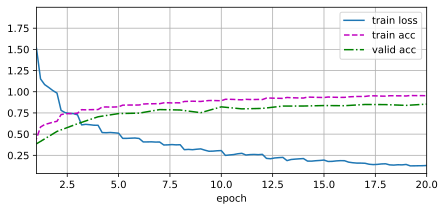

In [ ]:
''' Training and Validating the Model '''
devices, num_epochs, lr, wd = gpus, 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
net(next(iter(train_iter))[0]).to(devices[0])
train(
  net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

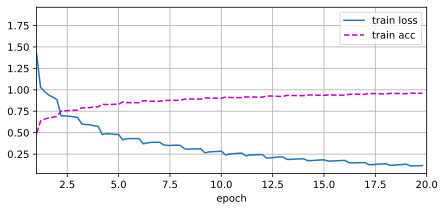

In [ ]:
''' Classifying the Test Set '''
net, preds = get_net(), []
net(next(iter(train_iter))[0]) #.to(devices[0])
batch_size = 128
train(
net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)

for X, _ in test_iter:
  y_hat = net(X.to(devices[0]))
  preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key=lambda x: str(x))

In [ ]:
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)